In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow import keras
from math import sqrt

from tensorflow.keras.utils import plot_model

In [15]:
class Stock:
    def __init__(self, stockName, filePath):

        self.data = pd.read_csv(filePath, header = 0, parse_dates=[0], index_col = 0, squeeze= True)
        self.data = self.data.dropna(0)
        
        self.name = stockName
       
        self.train_samplesX = np.array
        self.test_samplesX = np.array
        self.train_samplesY = np.array
        self.test_samplesY = np.array
        self.scaler = MinMaxScaler
    
        self.normalizedData = np.array
        self.normDataHistory = np.array
        self.nextDayVals = np.array
        self.nextDaysVals_test = np.array
        self.nextDayValsNorm = np.array
        self.model = keras.Model()
        
        self.indicators = np.array
        self.indicatorsNorm = np.array
        self.indicators_train = np.array
        self.indicators_test = np.array
        self.indicatorScaler = MinMaxScaler
        
        self.testProp = .2
        self.numLag = 1
        self.numSeq = 1
        self.numEpochs = 1
        self.numNeurons = 1
        self.batchSize = 32

    def show_head(self):
        print(self.data.head())

    def plot(self):
        register_matplotlib_converters()
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(21,3),dpi=300)
        
        
        ax1.set_title(self.name + " Longitudinal Open Prices")
        ax1.plot(self.data['Open'][::30])
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Stock Price USD [$]')
        
        ax2.set_title(self.name + " Longitudinal Volume")
        ax2.plot(self.data['Volume'][::30])
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Stock Volume')
        fig.savefig(self.name+"_plot.png")
        plt.show()
        

    def prepare_samples(self):
        self.scaler = MinMaxScaler(feature_range=(0,1))
        self.normalizedData = self.scaler.fit_transform(self.data)
        
        self.normDataHistory = np.array([self.normalizedData[i : i + self.numSeq].copy() for i in range(len(self.normalizedData)-self.numSeq)])
        self.nextDayValsNorm = np.array([self.normalizedData[:,0][i+self.numSeq].copy() for i in range(len(self.normalizedData)-self.numSeq)])
        self.nextDayValsNorm = np.expand_dims(self.nextDayValsNorm,-1)
        
        self.nextDayVals = np.array([self.data.values[:,0][i+ self.numSeq].copy() for i in range(len(self.data) - self.numSeq)])
        
        self.nextDayVals = np.expand_dims(self.nextDayVals,-1)
        
        yNormalizer = MinMaxScaler()
        yNormalizer.fit(self.nextDayVals)
        
        self.scaler = yNormalizer
        
        assert self.normDataHistory.shape[0] == self.nextDayValsNorm.shape[0]
    
    def prepare_indicators(self):
        indicators = []
        for day in self.normDataHistory:
            sma = np.mean(day[:,4])
            indicators.append(np.array([sma]))
            
        self.indicators = np.array(indicators)
        
        self.indicatorScaler = MinMaxScaler()
        self.indicatorsNorm = self.indicatorScaler.fit_transform(self.indicators)
        
        
            
        
    def split_data(self):
        split = self.normDataHistory.shape[0]-int(self.normDataHistory.shape[0] * self.testProp)
        
        self.train_samplesX, self.test_samplesX = self.normDataHistory[:split], self.normDataHistory[split:]
        self.train_samplesY, self.test_samplesY = self.nextDayValsNorm[:split],self.nextDayValsNorm[split:]
        self.nextDayVals_test = self.nextDayVals[split:]
    
    
    def split_indicator_data(self):
        split = self.indicatorsNorm.shape[0] - int(self.indicatorsNorm.shape[0] * self.testProp)
        
        self.indicators_train, self.indicators_test = self.indicatorsNorm[:split],self.indicatorsNorm[split:]
        
    
    
    def set_globals(self,testProp,batchSize,numSeq,numNeurons,numEpochs):
        self.testProp = testProp
        self.batchSize = batchSize
        self.numSeq = numSeq
        self.numNeurons = numNeurons
        self.numEpochs = numEpochs
        
        
    def fit_LSTM(self):
        lstm_input = keras.layers.Input(shape=(self.numSeq,self.data.shape[1]),name='lstm_input')
        dense_input = keras.layers.Input(shape=(self.indicators.shape[1],),name='ind_input')
        
        x = keras.layers.LSTM(self.numNeurons,name='LSTM_0')(lstm_input)
        x = keras.layers.Dropout(0.2,name='lstm_dropout_0')(x)
        lstm_branch = keras.Model(inputs=lstm_input,outputs=x)
        
        y = keras.layers.Dense(64,name='dense_0')(dense_input)
        y = keras.layers.Activation('sigmoid',name='sigmoid_0')(y)
        y = keras.layers.Dense(1,name='dense_1')(y)
        
        ind_branch = keras.Model(inputs=dense_input,outputs=y)
        
        complete = keras.layers.concatenate([lstm_branch.output,ind_branch.output],name='complete')
        
        z = keras.layers.Dense(64, activation = "sigmoid",name='dense_pooling')(complete)
        z = keras.layers.Dense(1,activation='linear',name='dense_out')(z)
    
        self.model = keras.Model(inputs=[lstm_branch.input,ind_branch.input],outputs=z)
        
        self.model.compile(optimizer='adam',loss='mse')
       # plot_model(model,to_file='model.png')
        
        self.model.fit(x=[self.train_samplesX,self.indicators_train],y=self.train_samplesY,batch_size=self.batchSize,epochs=self.numEpochs,shuffle=True,validation_split=.1)
        evaluation = self.model.evaluate([self.test_samplesX,self.indicators_test],self.test_samplesY)
        print(evaluation)
            
    
    def evaluate_forecasts(self):

        predictedPrices = self.model.predict([self.test_samplesX,self.indicators_test])
        predictedPrices = self.scaler.inverse_transform(predictedPrices)
        
        MSE = np.mean(np.square(self.nextDayVals_test - predictedPrices))
        MSE_scaled = MSE / (np.max(self.nextDayVals_test) - np.min(self.nextDayVals_test)) * 100
        print("MSE Score: " +MSE_scaled)
        
        rSquared = r2_score(self.nextDayVals_test,predictedPrices)
        print("R^2 Score: " +rSquared)
        
        fig = plt.figure(figsize=(20,10),dpi=300)
        actual = plt.plot(self.nextDayVals_test,label='actual')
        predicted = plt.plot(predictedPrices,label='predicted')
        plt.legend(['Actual','Predicted'])
        plt.show()
        fig.savefig(self.name+"forecastplot"+self.numEpochs+".png")
        
        
 
        
   

                Open      High       Low     Close  Adj Close       Volume
Date                                                                      
1980-12-12  0.513393  0.515625  0.513393  0.513393   0.406782  117258400.0
1980-12-15  0.488839  0.488839  0.486607  0.486607   0.385558   43971200.0
1980-12-16  0.453125  0.453125  0.450893  0.450893   0.357260   26432000.0
1980-12-17  0.462054  0.464286  0.462054  0.462054   0.366103   21610400.0
1980-12-18  0.475446  0.477679  0.475446  0.475446   0.376715   18362400.0
Train on 7581 samples, validate on 843 samples
Epoch 1/50
7581/7581 [==============================] - 3s 407us/sample - loss: 0.0073 - val_loss: 3.2108e-05

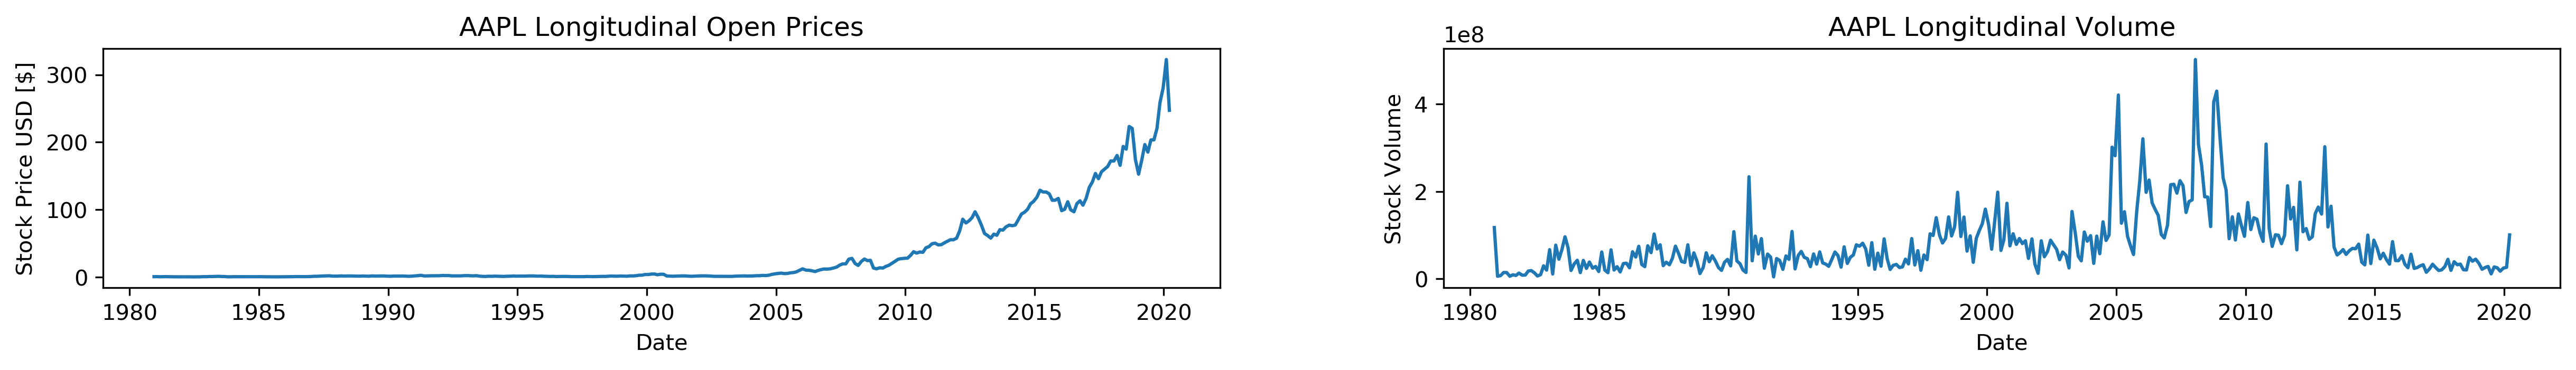

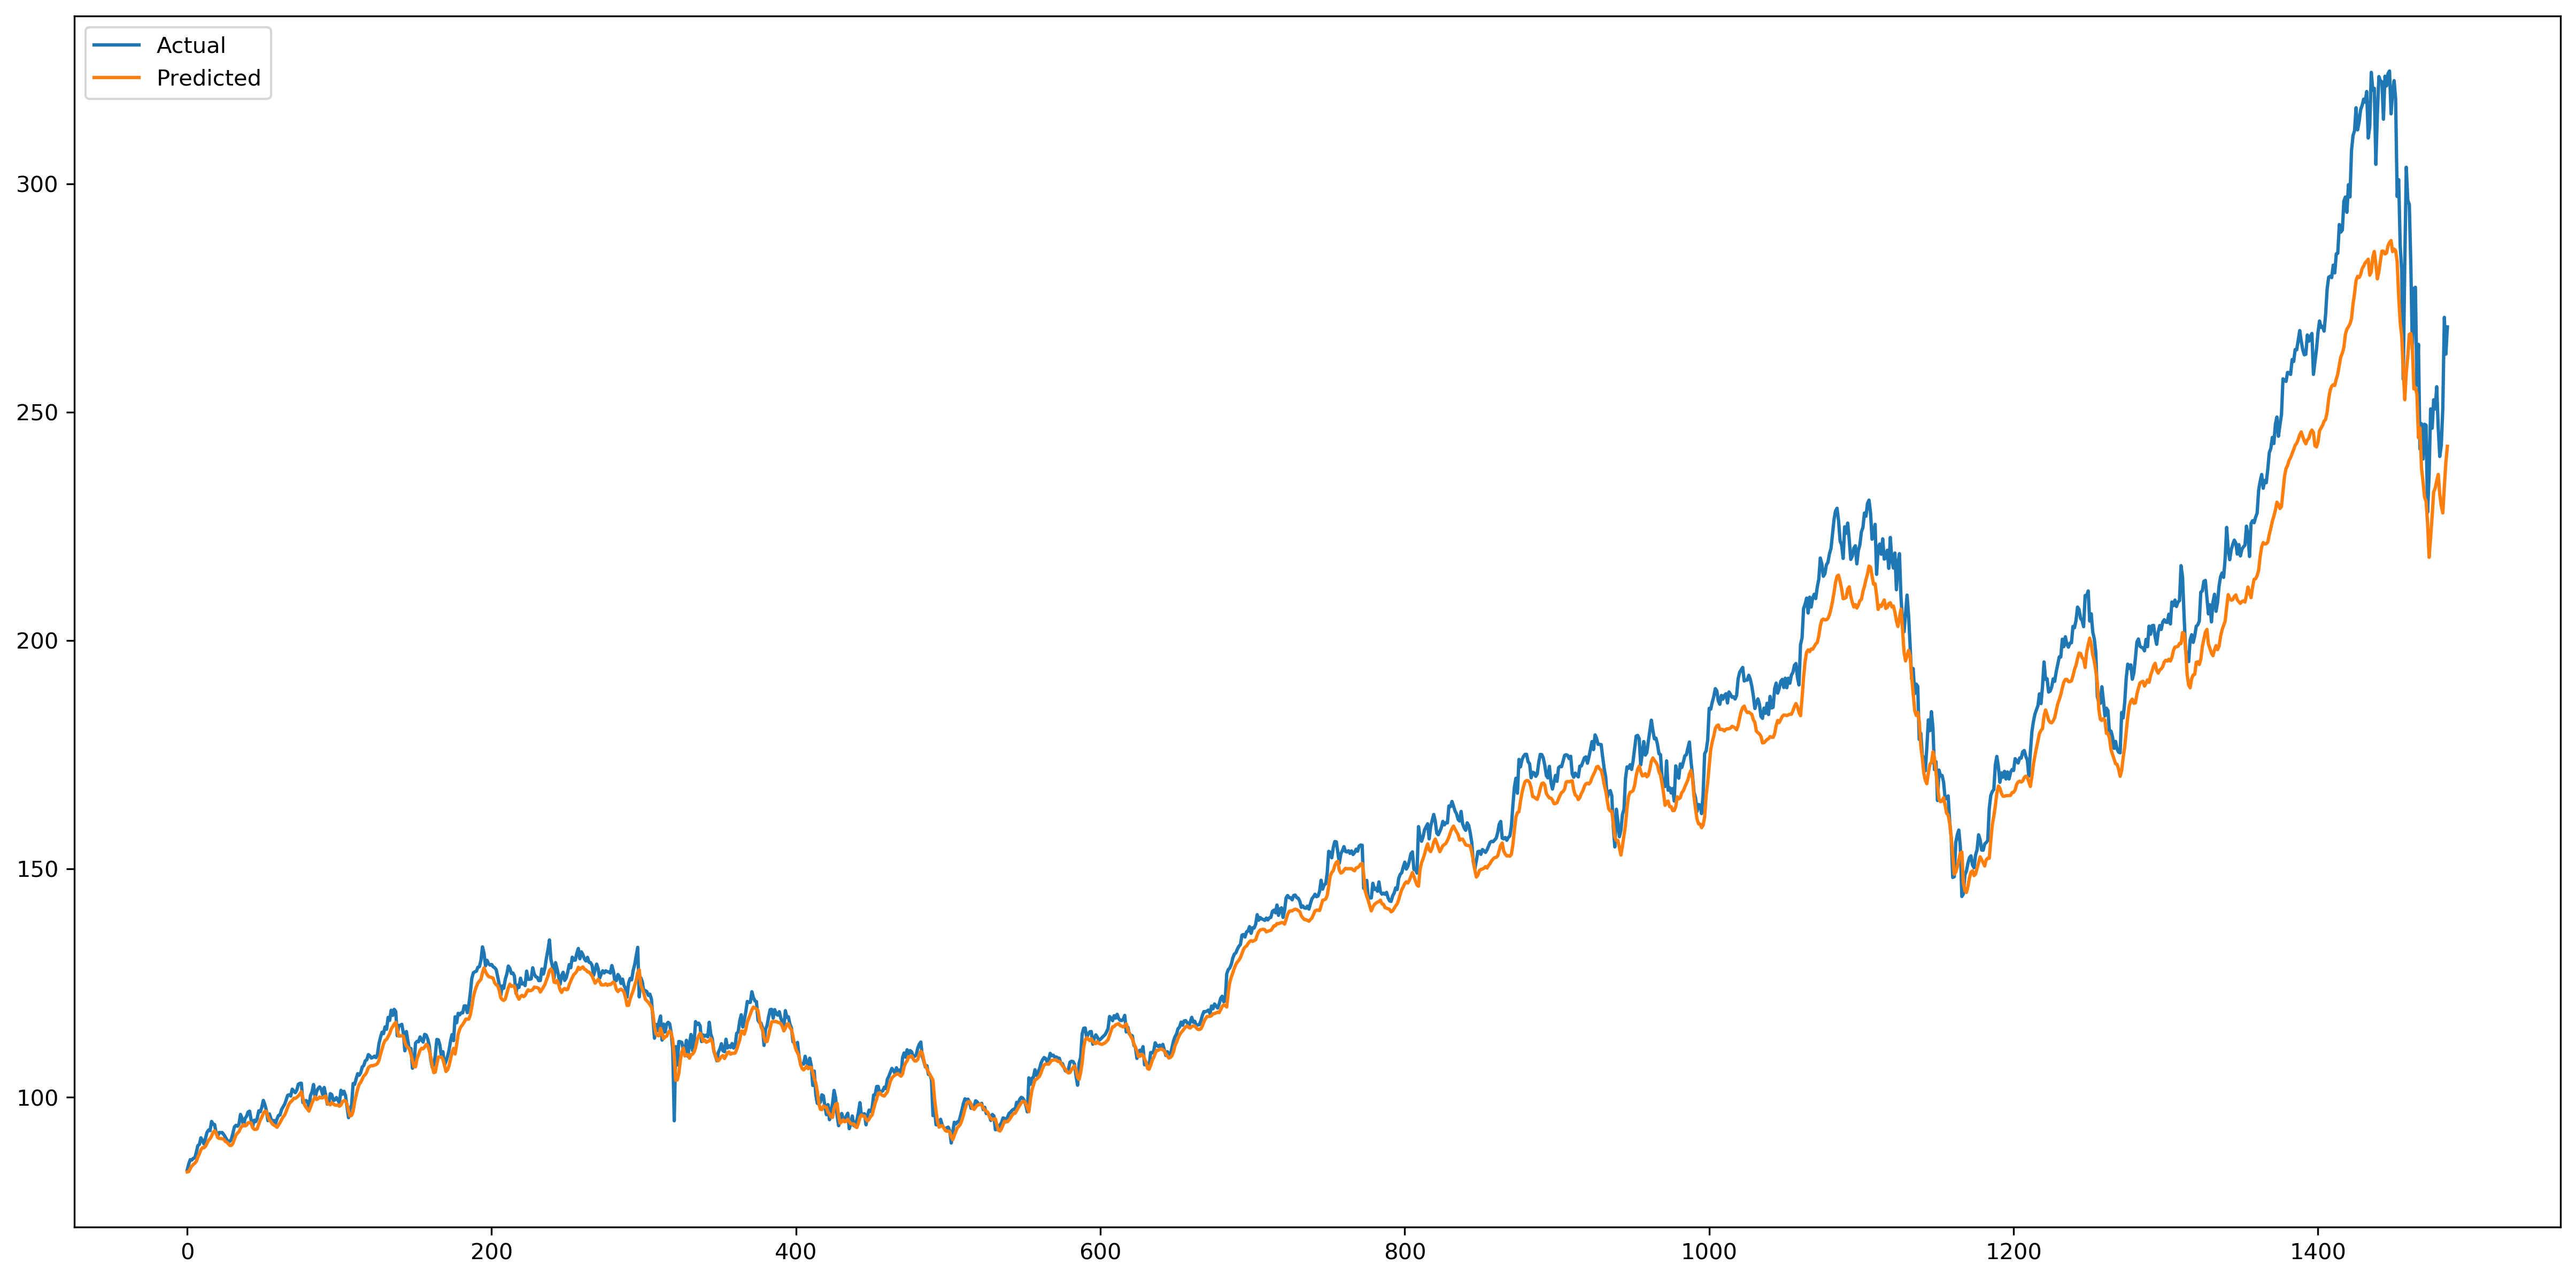

In [3]:

AAPL = Stock("AAPL","AAPL.csv")
AAPL.set_globals(.15,32,5,50,5)
AAPL.show_head()
AAPL.plot()
AAPL.prepare_samples()
AAPL.prepare_indicators()
AAPL.split_data()
AAPL.split_indicator_data()
AAPL.fit_LSTM()
AAPL.evaluate_forecasts()



                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2006-05-22  36.520000  37.290001  35.869999  37.230000  34.038883  197100
2006-05-23  37.750000  39.220001  37.750000  37.959999  34.706322  620900
2006-05-24  37.130001  37.570000  35.869999  36.520000  33.389740  638600
2006-05-25  37.180000  38.320000  36.980000  38.320000  35.035458  367000
2006-05-26  38.740002  38.740002  37.770000  38.549999  35.245750  269400


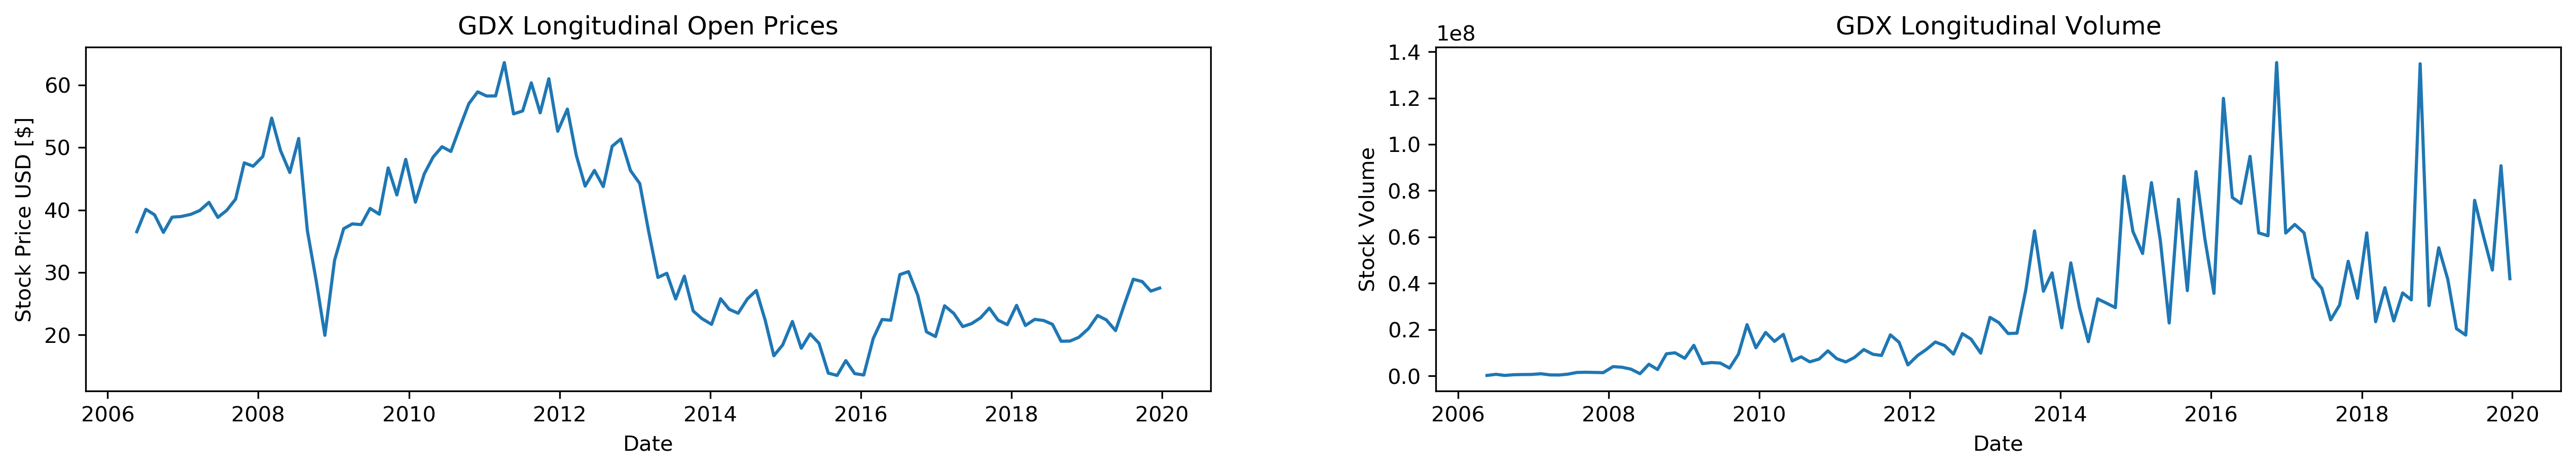

Train on 2621 samples, validate on 292 samples
Epoch 1/5
2621/2621 [==============================] - 2s 833us/sample - loss: 0.0221 - val_loss: 5.7283e-04
Epoch 2/5
2621/2621 [==============================] - 0s 140us/sample - loss: 0.0024 - val_loss: 2.7395e-04
Epoch 3/5
2621/2621 [==============================] - 0s 138us/sample - loss: 0.0021 - val_loss: 2.5894e-04
Epoch 4/5
2621/2621 [==============================] - 0s 138us/sample - loss: 0.0018 - val_loss: 2.1819e-04
Epoch 5/5
513/513 [==============================] - 0s 54us/sample - loss: 2.0365e-04
0.00020365253148498793
4.485481265091427
0.9407653188624263


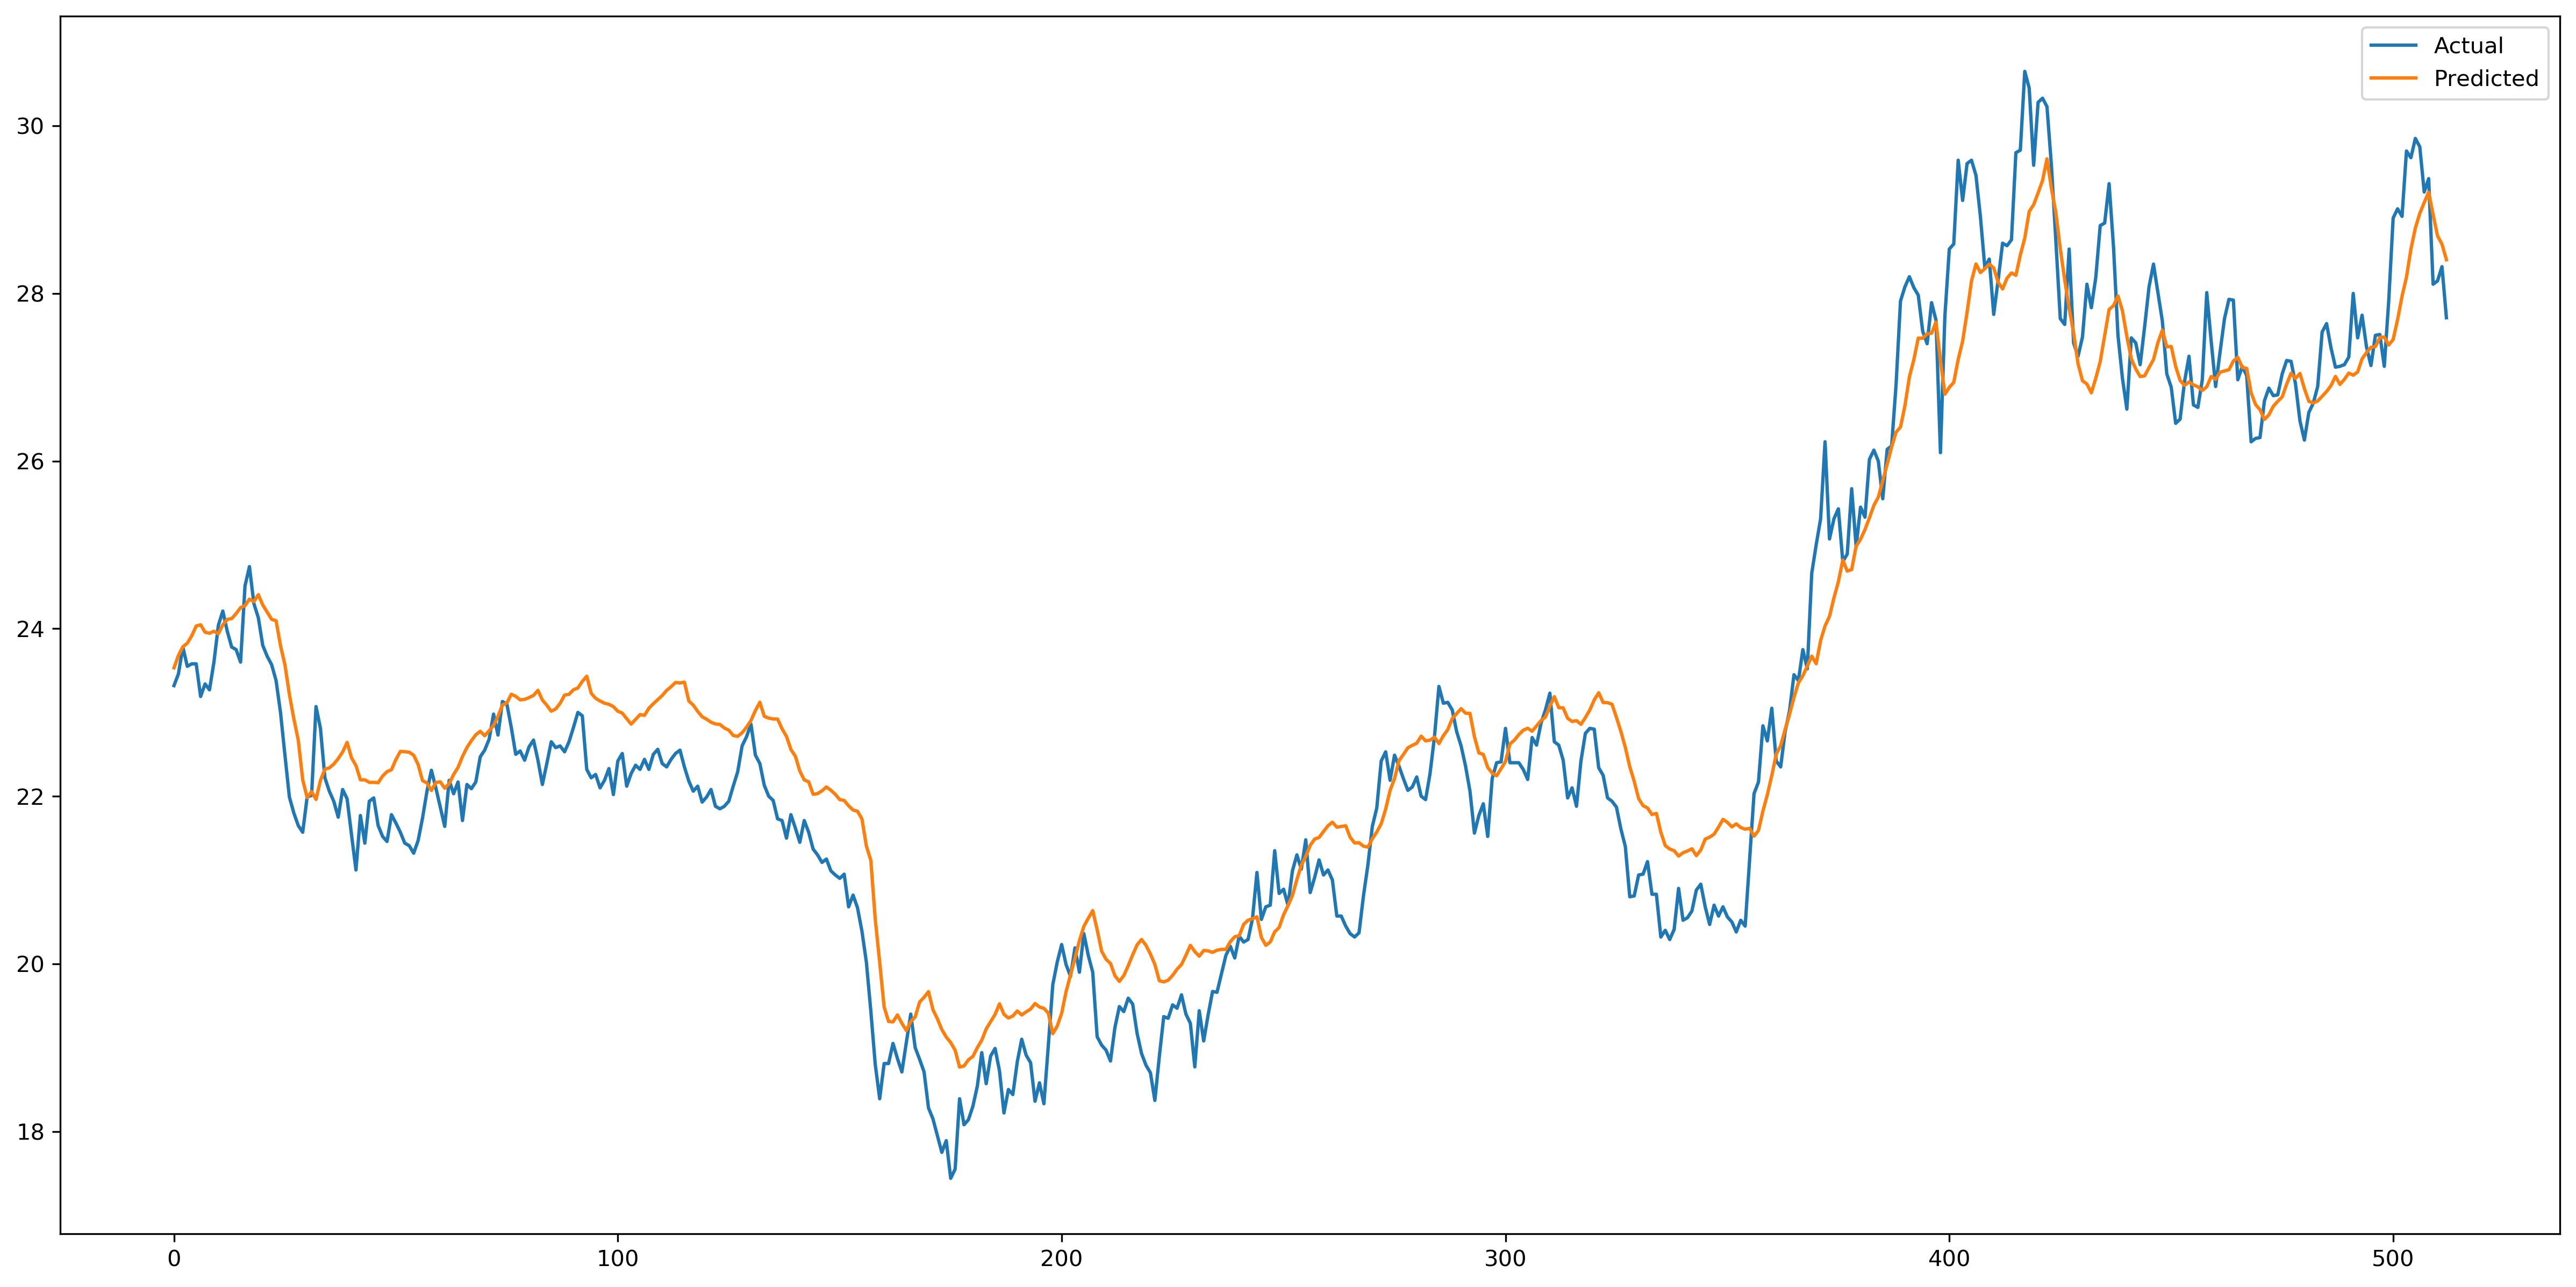

TypeError: can only concatenate str (not "int") to str

In [16]:
GDX = Stock("GDX","GDX.csv")
GDX.set_globals(.15,32,10,50,5)
GDX.show_head()
GDX.plot()
GDX.prepare_samples()
GDX.prepare_indicators()
GDX.split_data()
GDX.split_indicator_data()
GDX.fit_LSTM()
GDX.evaluate_forecasts()



                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2005-01-03  40.090000  40.290001  39.369999  39.500000  34.919861  100970900
2005-01-04  39.669998  39.740002  38.549999  38.779999  34.283333  136623200
2005-01-05  38.680000  38.959999  38.470001  38.540001  34.071182  127925500
2005-01-06  38.630001  38.709999  38.340000  38.349998  33.903210  102934600
2005-01-07  38.560001  38.869999  38.209999  38.549999  34.080021  123104000
Train on 2891 samples, validate on 322 samples
Epoch 1/50
2891/2891 [==============================] - 3s 900us/sample - loss: 0.0090 - val_loss: 2.1295e-04

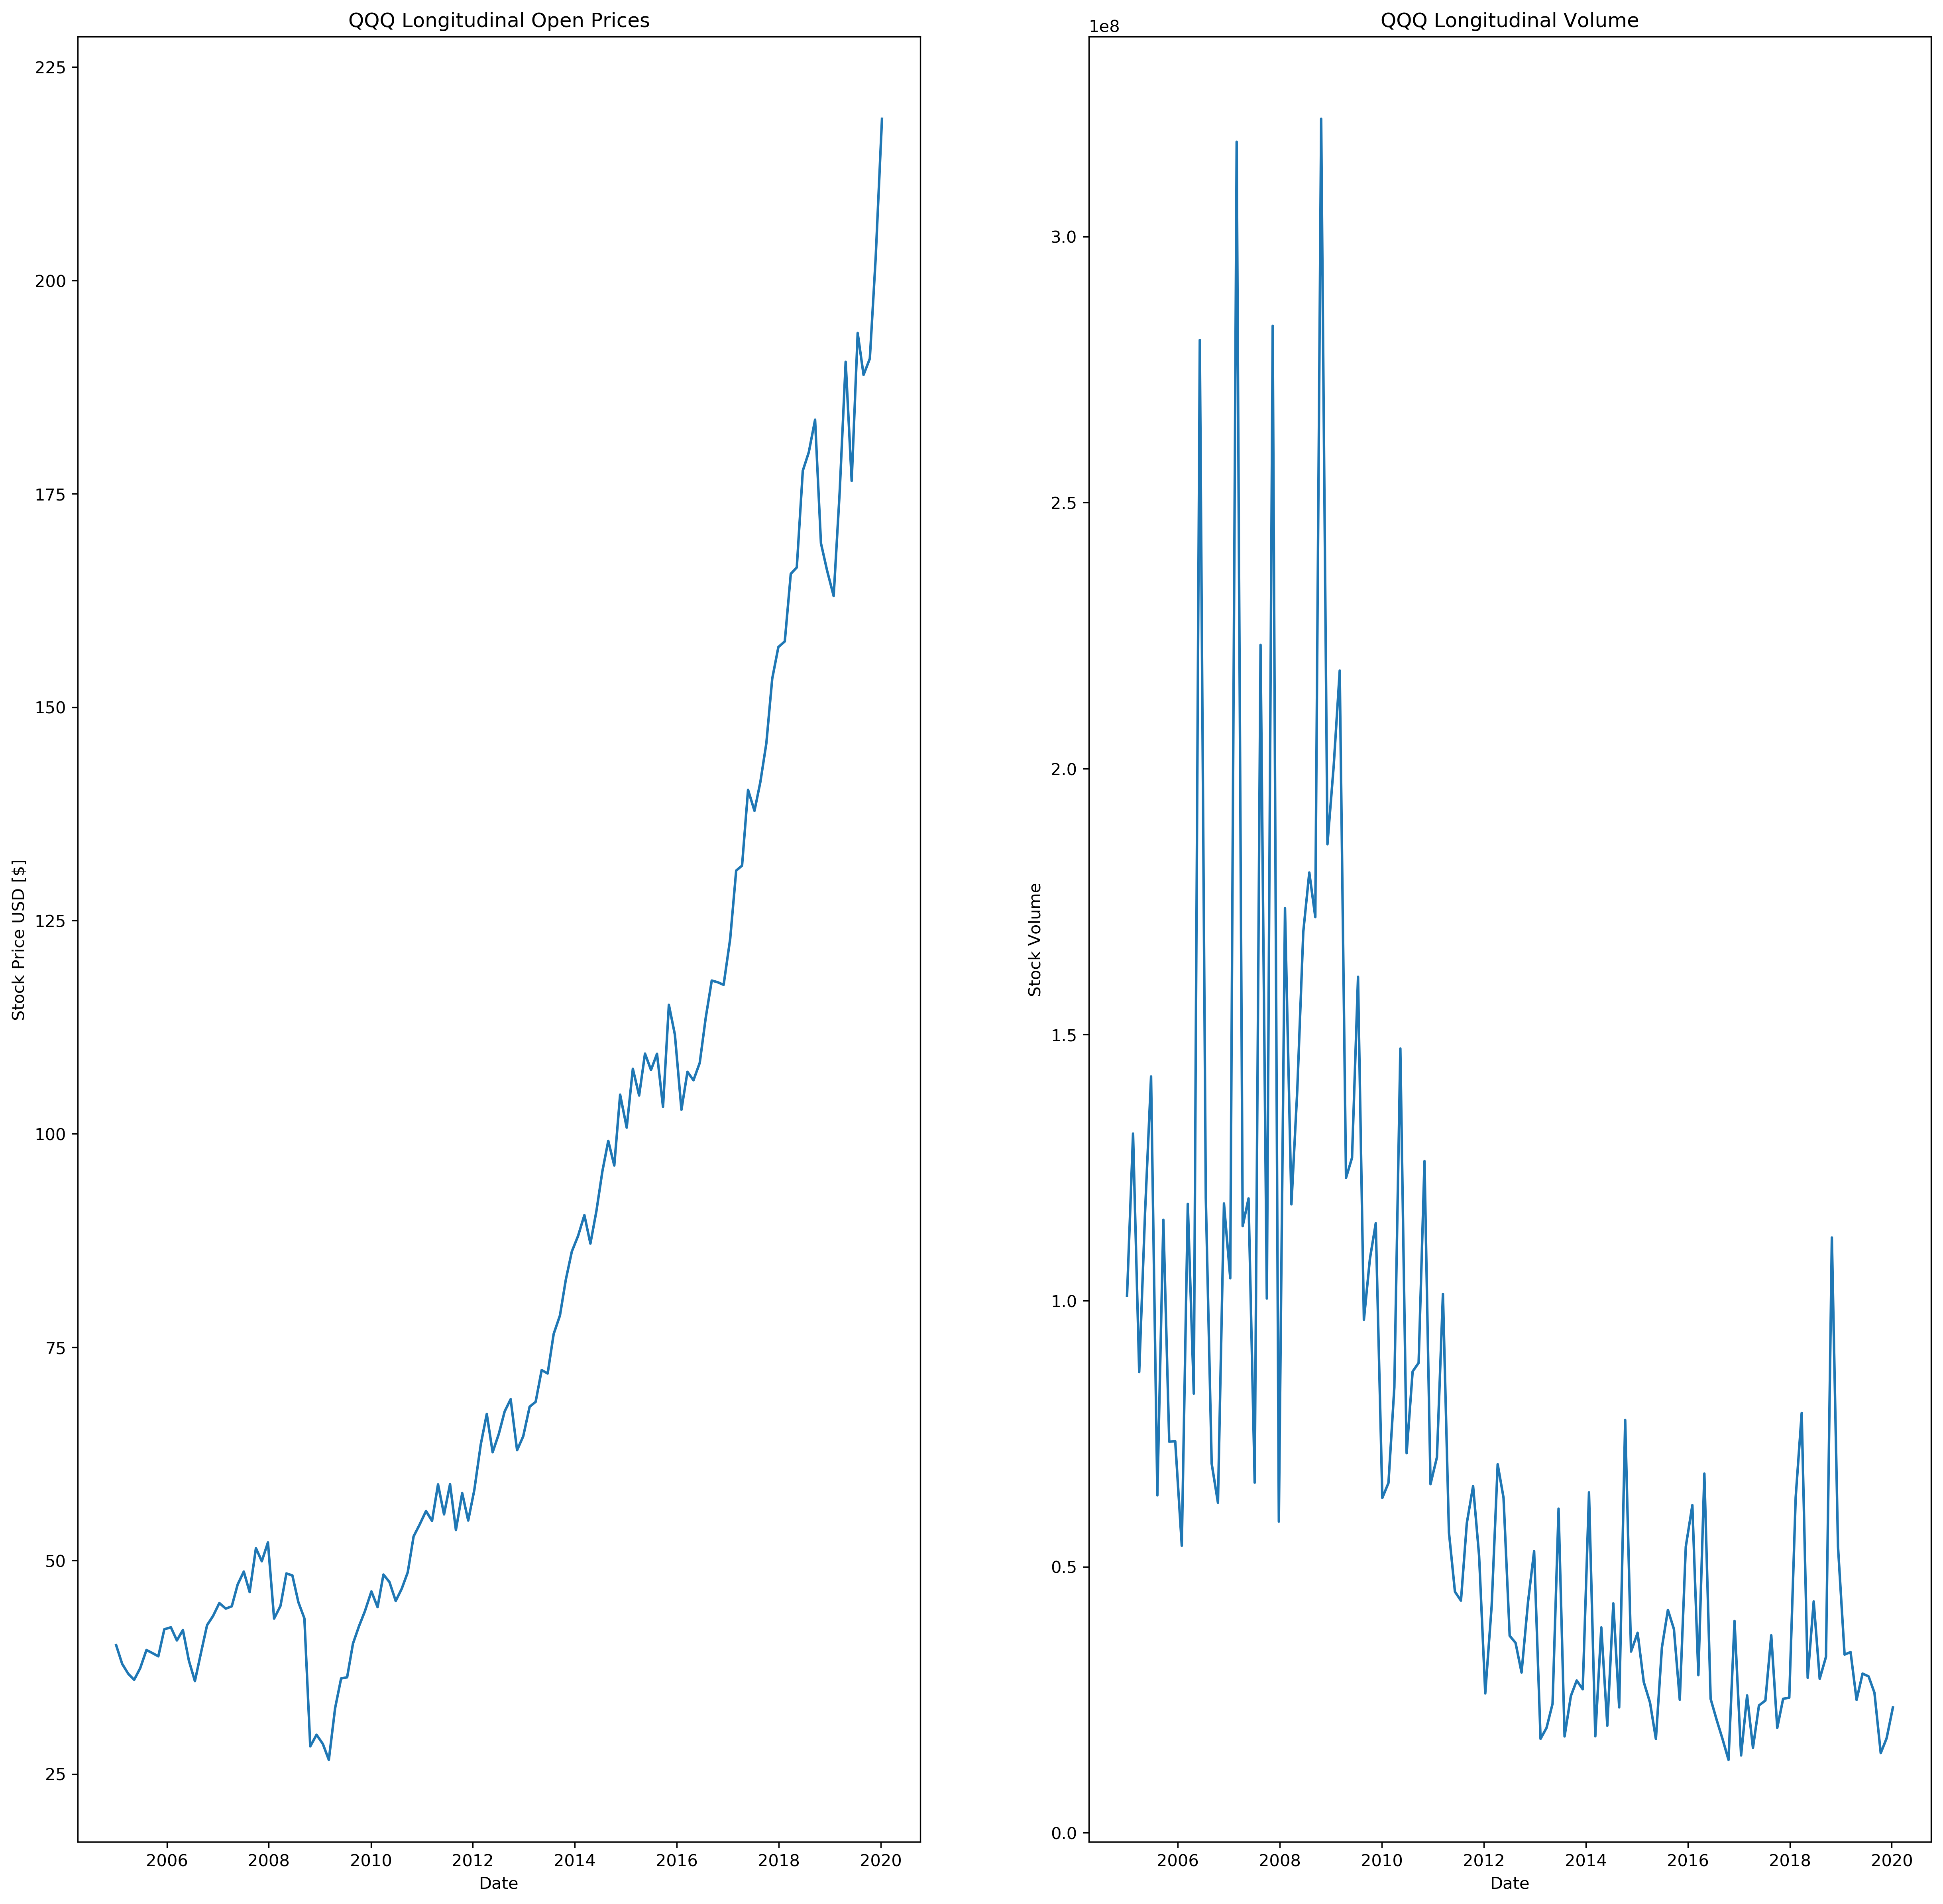

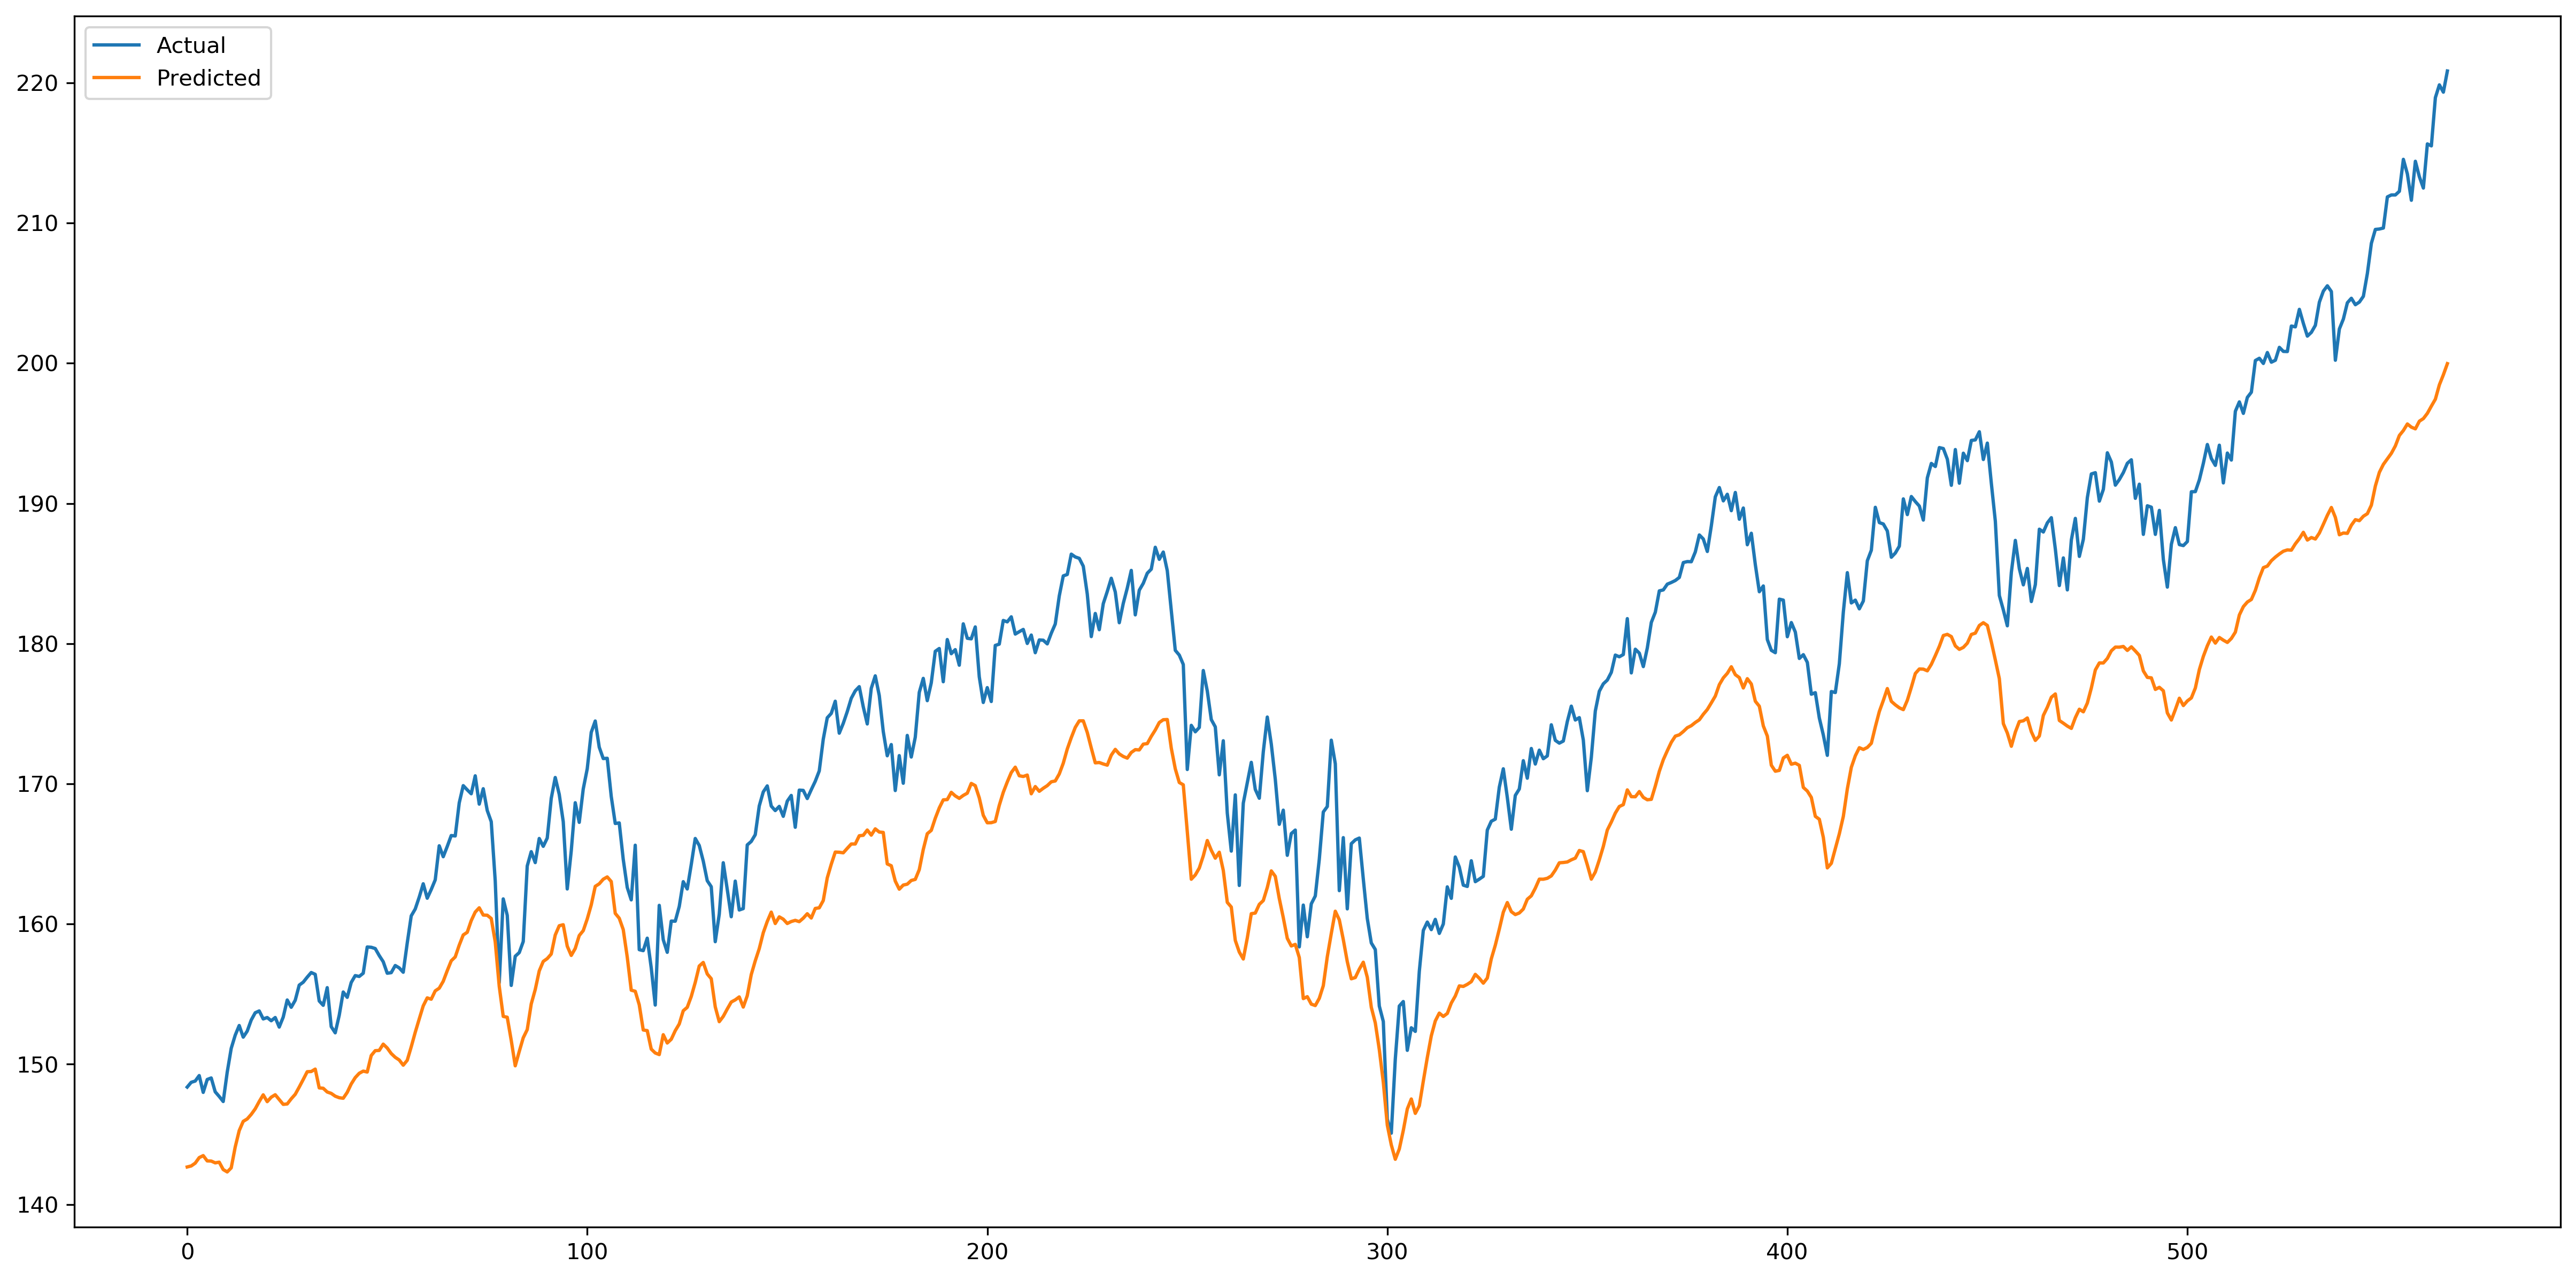

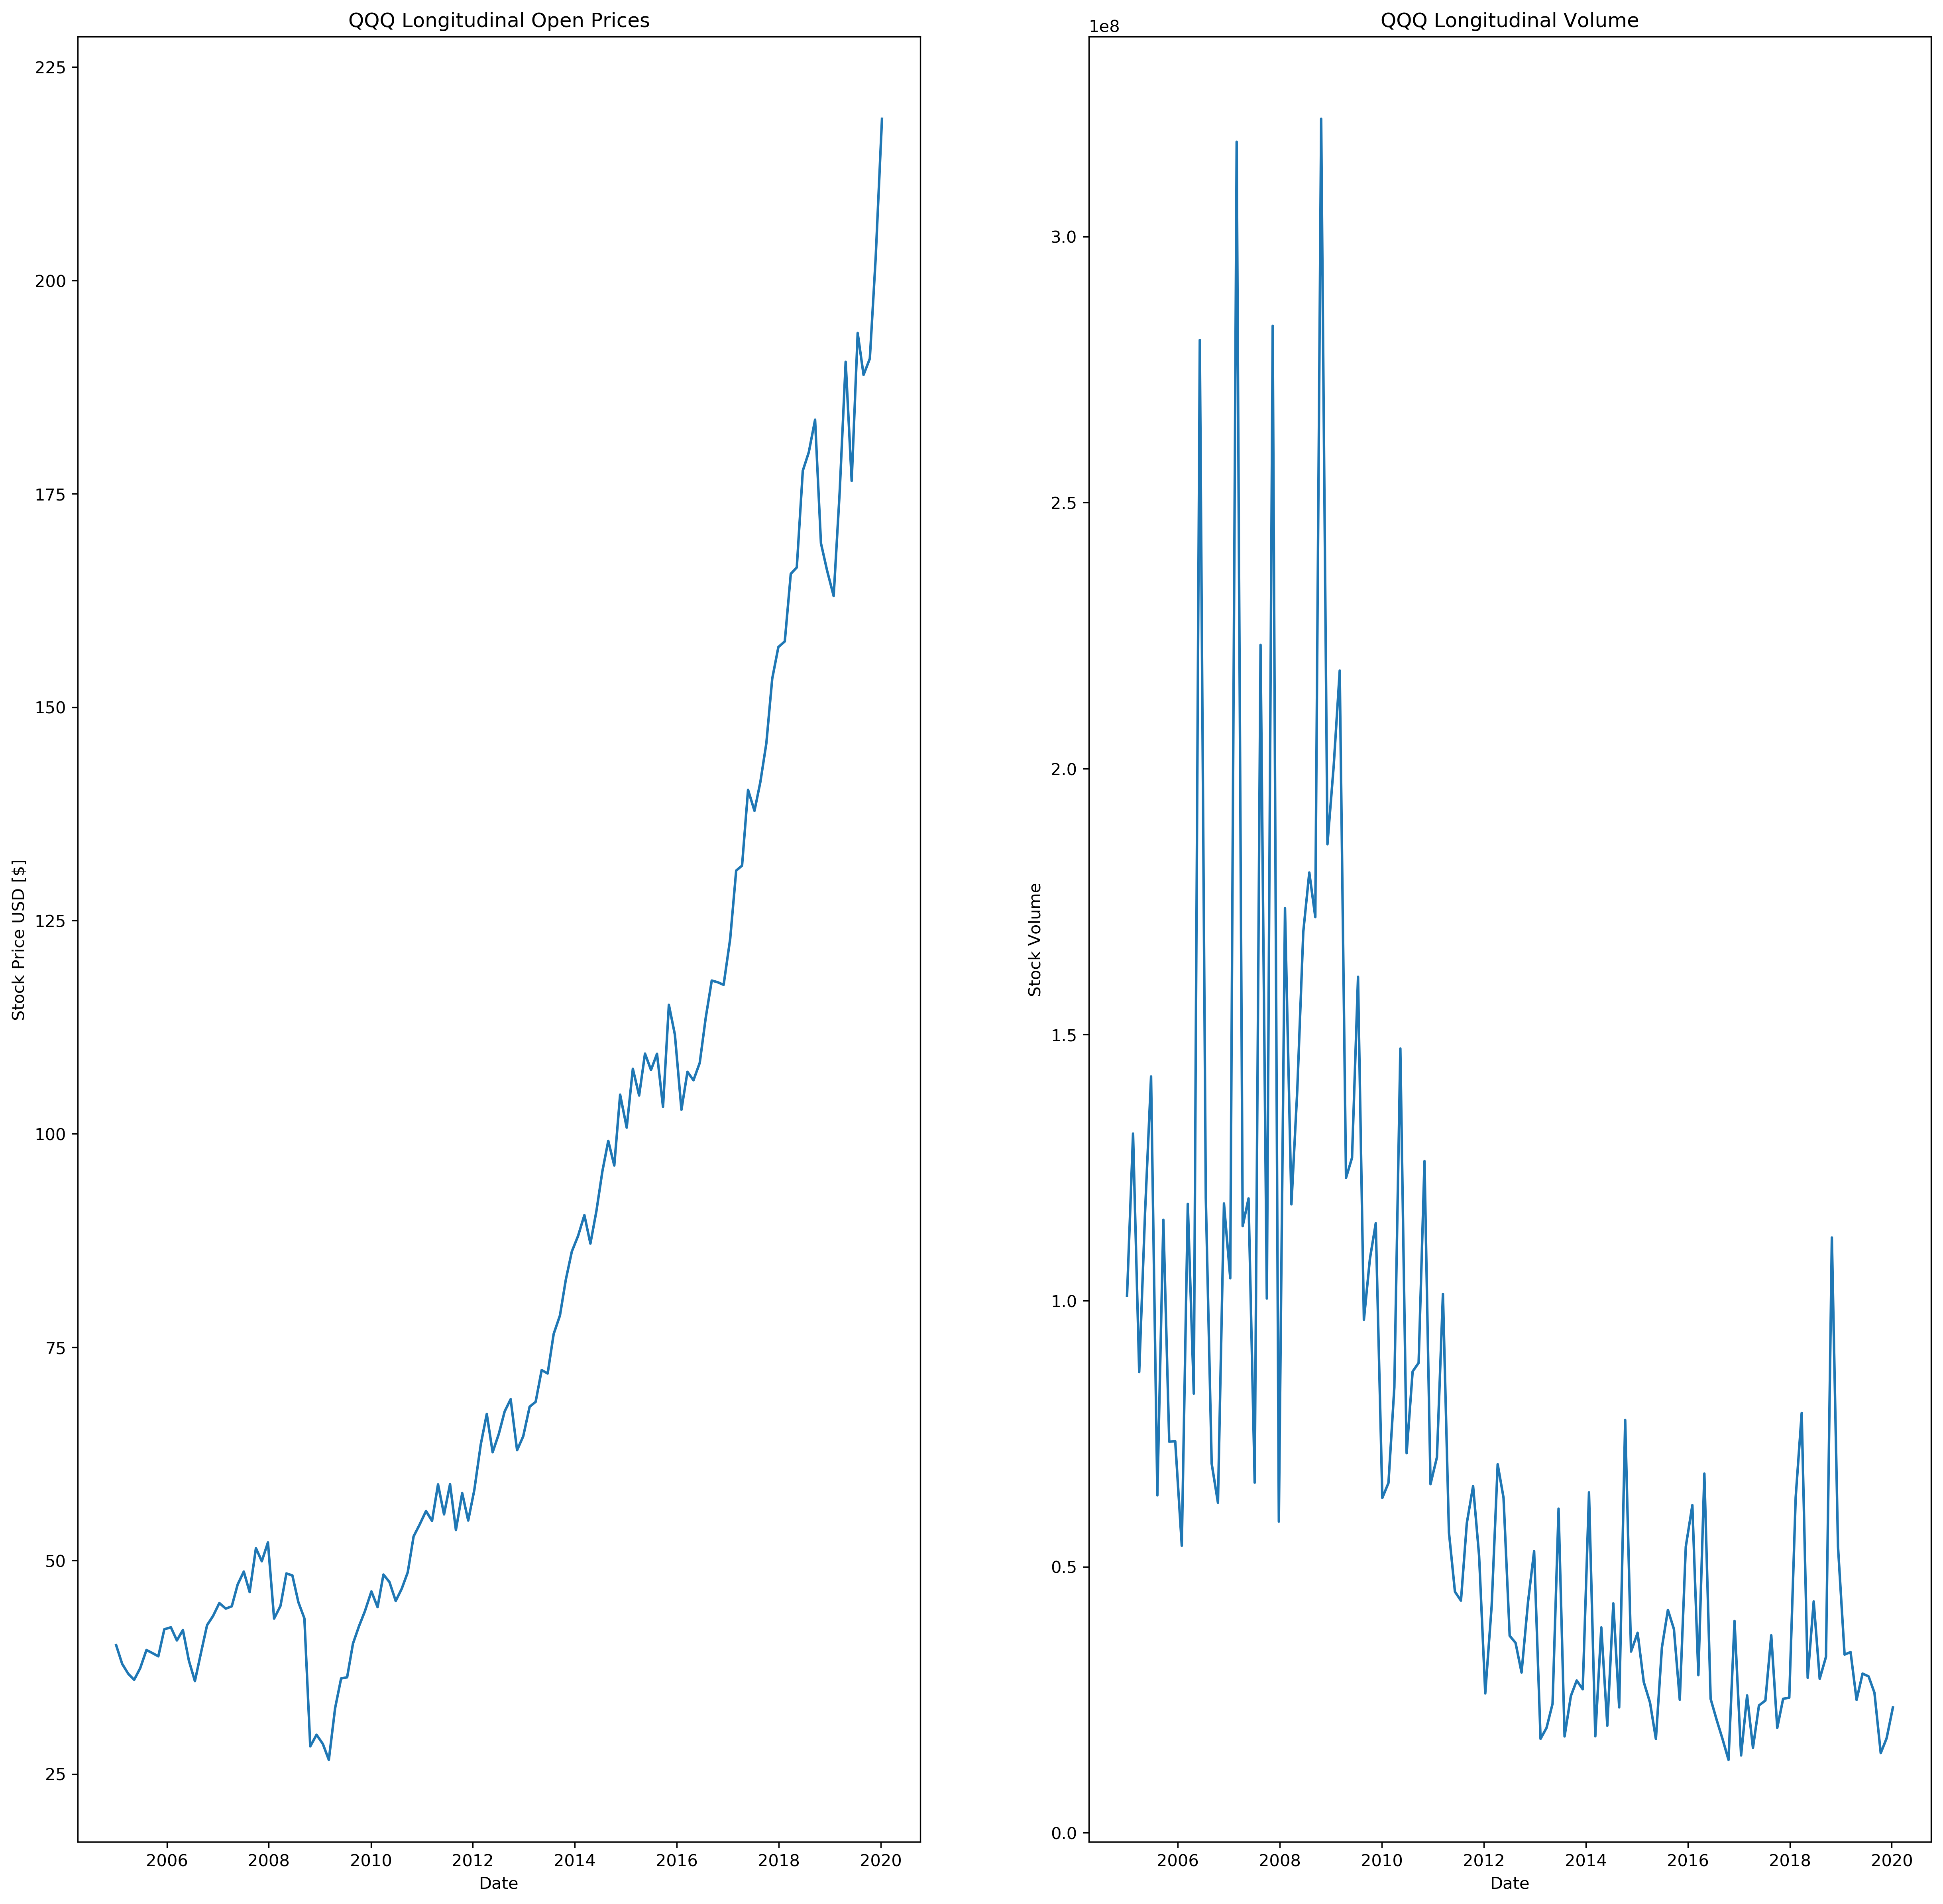

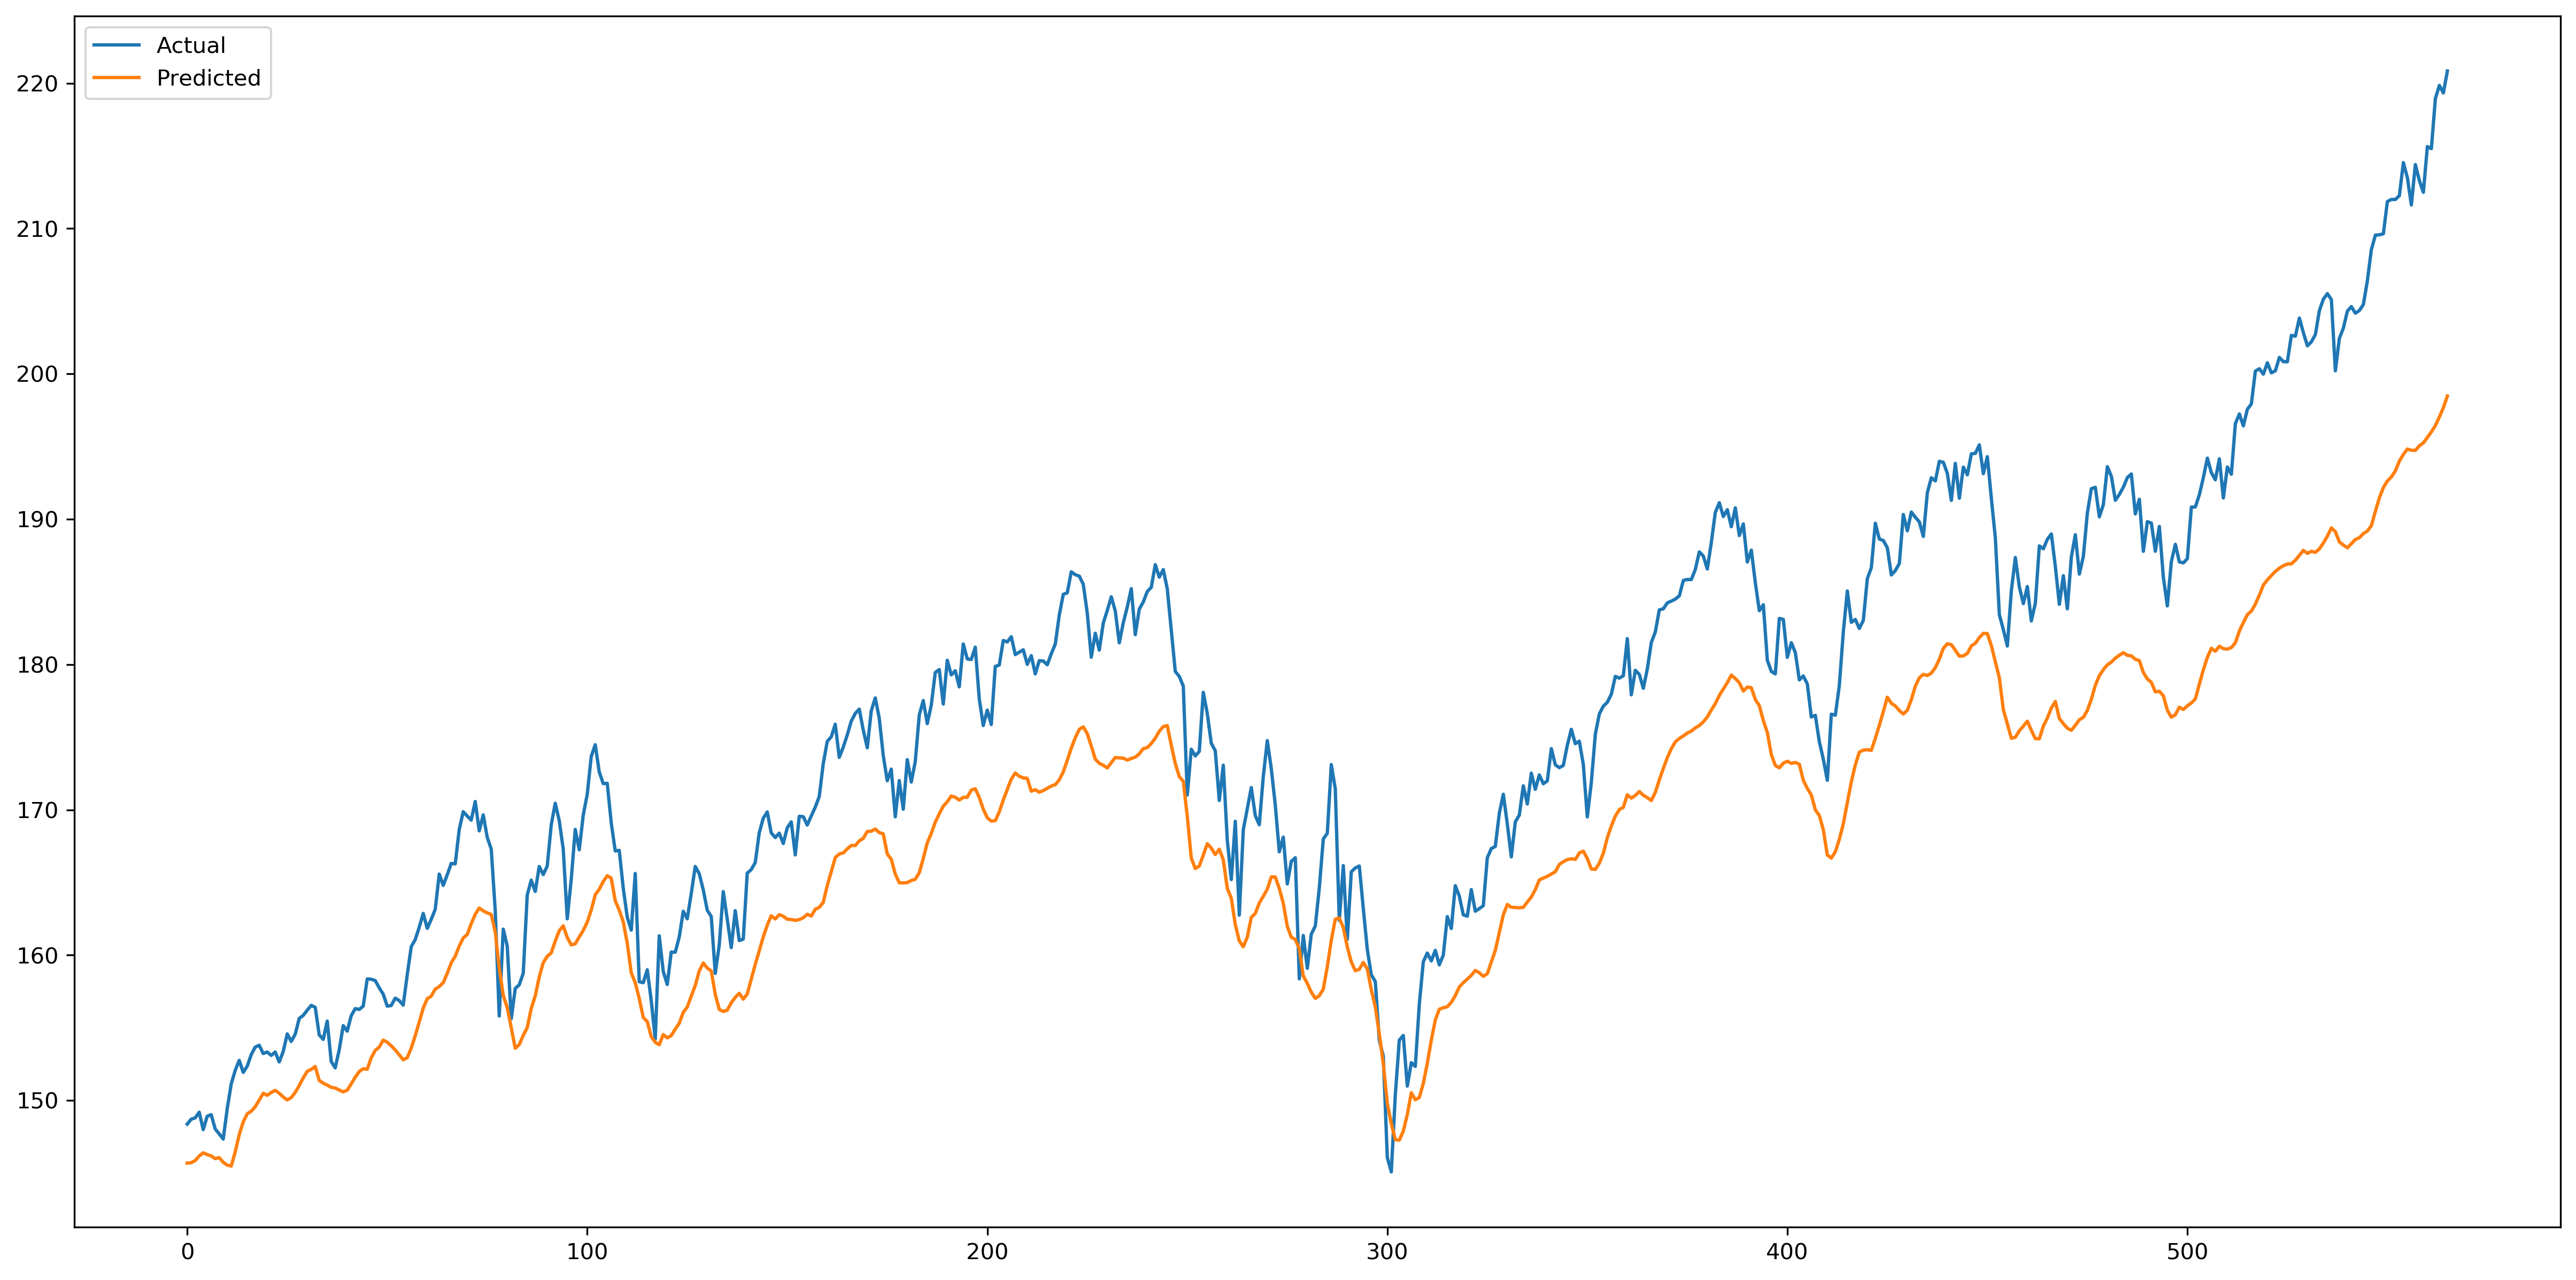

In [24]:
QQQ = Stock("QQQ","QQQ.csv")
QQQ.set_globals(.15,32,5,50,50)
QQQ.show_head()
QQQ.plot()
QQQ.prepare_samples()
QQQ.prepare_indicators()
QQQ.split_data()
QQQ.split_indicator_data()
QQQ.fit_LSTM()
QQQ.evaluate_forecasts()

